<a href="https://colab.research.google.com/github/AndresMontesDeOca/RegresionAvanzada/blob/main/Machete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MACHETE

#### Logbook

In [1]:
# 31/05/23 -> Creacion de la Notebook
# 31/05/23 -> Tests Normalidad, Homocedasticidad Residuos
# 06/06/23 -> Test No-autoorrelacion de Residuos
# 17/06/23 -> Transfomraciones Box Clox
# 19/06/23 -> Migrated to Google Colab
# 20/06/23 -> R Magic
# 22/06/23 -> Deteccion Outliers e Influyentes

In [2]:


# Autor: Andres Montes de Oca

# Instalacion de Paquetes
!pip install pingouin # No incluido en Google Colab
# !pip install scipy
# !pip install statsmodels


# Cargamos Librerias y Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt

# Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

# Asthetics
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1, color_codes=True)

# Recursion limit errors with R Magic
import sys
# sys.setrecursionlimit(50000)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=931a54de163c024aa63fc99e62e12b6e27e866e63e62ffe8a25779d46fe617b1
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


## R Magic in Google Colab

In [3]:
# Version rpy2 que no tiene problemas de compatibilidad
!pip install rpy2==3.5.1

# activate R magic
%load_ext rpy2.ipython

# Import rpy2 for dataframe conversion
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import globalenv


# ###### Pandas DataFrames and Series conversion ########
# # Cargamos un DataSet cualquira en Python, para que no de error
# data_P = sns.load_dataset('iris')
# Serie = data_P['petal_length']

# # Convert the Python DataFrame to the R dataframe
# %R -i data_P

# with localconverter(ro.default_converter + pandas2ri.converter):
#   data_R = ro.conversion.py2rpy(data_P)
# # Create a variable name in R's Global Environment
# globalenv['data_R'] = data_R

# # Convert Python Series to R vectors
# vec_float_R = ro.vectors.FloatVector(Serie)
# # vec_int_R = ro.vectors.IntVector(Serie)
# # vec_str_R = ro.vectors.StrVector(Serie)
# globalenv['vec_float_R'] = vec_float_R

# # Convert R datadrame/vector to Python DataFrame/Vector
# %R -o data_R

# with localconverter(ro.default_converter + pandas2ri.converter):
#   data_P = ro.conversion.rpy2py(data_R)

# # Importar R-Functions a Python como Objetos(sin uso)
# shapiro_test = ro.r('shapiro.test')
# result = shapiro_test(vec_float_R)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=318077 sha256=adb5245034a47616a87dbdf41f885dfc3bed23af6e899e796a68ceb7bed1fa24
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


#### Instalaciones Individuales en Bash

In [4]:
# system(sudo apt install libgsl-dev) # -> Rapido

#### Instalacion de Librerias para R en Google Colab

In [5]:
%%R

### MVN Henze-Zirkler Test ### -> Lento
# # system(sudo apt install libgsl-dev)
# install.packages('MVN')

### Wald Test ### -> Rapido
# install.packages('aod')

### QQ Plot, Bonferroni ### -> Lento
# install.packages('car')

### LRM Tests ###
# install.packages('lmtest')

### Box-Cox Transformation ### -> Rapido
# install.packages('MASS')


####################################
### Installation Status ###
# print(system.file(package='MVN'))

NULL


## Cargas de Datasets from Google Drive

In [6]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Grasa de Cerdos
id = '153lGVzdixcHT-keKg8qmvaoWdPHg6_tB'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('grasacerdos.xlsx')
dataG = pd.read_excel('grasacerdos.xlsx', index_col='Obs') # Cargamos el Dataset
dataG = dataG.replace(to_replace=',', value='.', regex=True) # Reemplazo , por .
dataG = dataG.astype('float') # Transformo en float
%R -i dataG

######################################################
# Peso, Edad, Colesterol
id = '17Dv1WcWlc9ojWa6bnSfD7TCRaVKCKqj0'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('peso_edad_colest.xlsx')
dataP = pd.read_excel('peso_edad_colest.xlsx')
%R -i dataP

# # Convert the Python DataFrame to the R dataframe
# with localconverter(ro.default_converter + pandas2ri.converter):
#   dataP_R = ro.conversion.py2rpy(dataP)
# # Create a variable name in R's Global Environment
# globalenv['dataP_R'] = dataP_R

######################################################
# Cars con Modelo Lineal
id = '15pf-6P4Ek2rp6mYmfOybHRqAxqOoTp6i'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('cars.csv')
dataC = pd.read_csv('cars.csv')
model_cars = smf.ols('dist ~ speed', data=dataC).fit()
%R -i dataC

######################################################
# University
id = '16kLQNXhyweAi38xR2IeQCCagVcU725UZ'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('University.csv')
dataU = pd.read_csv('University.csv')
%R -i dataU

######################################################
# Iris(Python)
dataI = sns.load_dataset('iris')

# # Iris(R) -> DataFrame to dataframe
# with localconverter(ro.default_converter + pandas2ri.converter):
#   dataI_R = ro.conversion.py2rpy(dataI.drop(columns='species'))
# # Create a variable name in R's global environment
# globalenv['dataI_R'] = dataI_R

# # Serie to Vector
# x_R = ro.FloatVector(dataI['petal_length'])
# w_R = ro.FloatVector(dataI['petal_width'])
# globalenv['x_R'] = x_R
# globalenv['w_R'] = w_R
%R -i dataI

######################################################
# Gorriones
id = '15G6jIOMiuWaTs-qy7eUXwhED4delBMl6'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('gorriones.xlsx')
dataO = pd.read_excel('gorriones.xlsx')
dataO.rename(columns=
            {'largototal':'Largo', 'extension ':'Alas', 'cabeza':'Cabeza',
             'humero':'Pata', 'esternon':'Cuerpo', 'sobrevida ':'Target'},
            inplace=True)
%R -i dataO


# 1) Relacion Lineal
Relationship between independent var (x) and depedent var (y) is linear

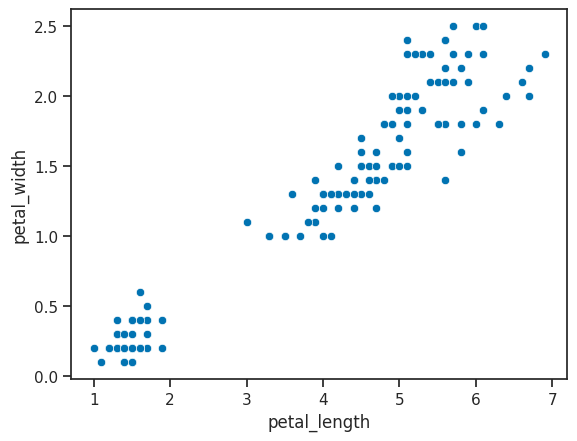

In [7]:
sns.scatterplot(data=dataI, x='petal_length', y='petal_width')
plt.show()

# Transformmations for making relationships linear. Polynomial or Exponential for any of both

# 2) Multicollonearity
Eeach independent variable should be independent from other independent variables

,n,r,CI95%,p-val,BF10,power
pearson,150,0.962865,"[0.95, 0.97]",4.675004e-86,1.113e+82,1.0


,n,r,CI95%,p-val,power
spearman,150,0.937667,"[0.91, 0.95]",8.156597e-70,1.0


<Axes: >

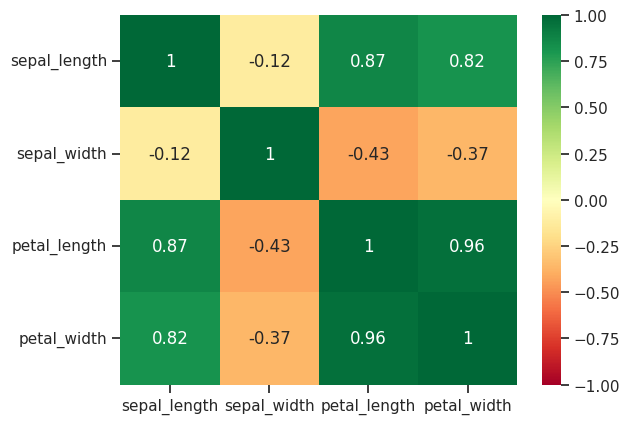

In [8]:
display(pg.corr(dataI['petal_length'], dataI['petal_width'], method='pearson')) # Entre dos varibales, H0 -> Variables Independientes
display(pg.corr(dataI['petal_length'], dataI['petal_width'], method='spearman')) # Cuando no se cumplen los supuestos de Pearson
display(sns.heatmap(dataI.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos

# 3) Bi-Variate Normality
Multivariate Normality in Variables

,W,pval,normal
sepal_width,0.984917,0.101126,True


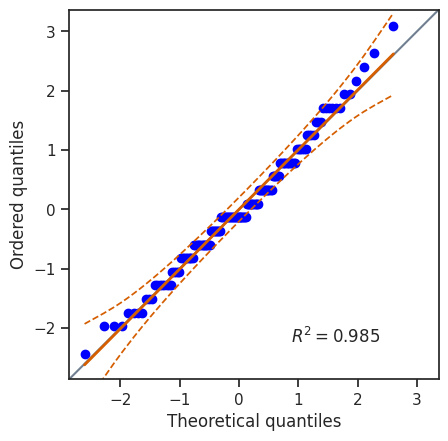

HZResults(hz=2.3363942003154383, pval=4.141311629927849e-19, normal=False)


In [9]:
# Tests analiticos para Single
display(pg.normality(dataI['sepal_width'])) # Shapiro Test(single Var), H0 -> Normal Dist

# Otros tests
# st.anderson(dataI['sepal_width'], dist='norm') # Anderson-Darling SciPy
# st.kstest(dataI['sepal_width'], 'norm')# Kolmogorov-Smirnov SciPy

# Test grafico para Single
pg.qqplot(dataI['sepal_width']) # QQ Plot
plt.show()

# Test analitico para Multi
print(pg.multivariate_normality(dataI.drop(columns='species'))) # Henze-Zirkler Test, H0 -> Multiv Normal Dist

#### R Magic

In [10]:
# Otros Tests en R
%%R

# library(car)
# qqPlot(dataI$sepal_width) # Observaciones que romperian con el supuesto de Normalidad

# library(MVN)
# mvn_result <- mvn(dataI, mvnTest = 'hz')
# print(mvn_result)

NULL


# X) Linear Regression Models

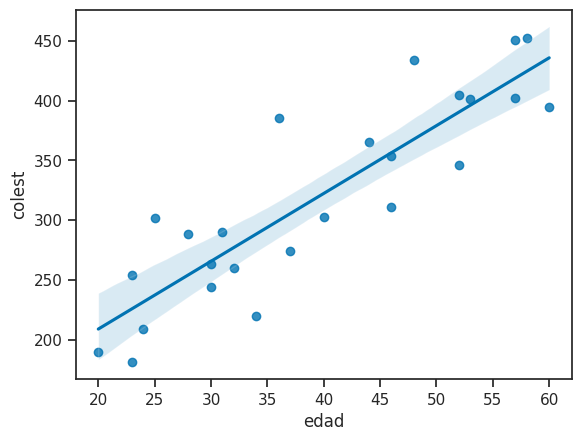

In [11]:
# LRM en Python
dataP = sm.add_constant(dataP)
model_colest = smf.ols('colest ~ edad', data=dataP).fit()

sns.regplot(data=dataP, x='edad', y='colest')
plt.show()

#### R Magic

In [12]:
# LRM en R
%%R

model_colest_R = lm('colest ~ edad', data=dataP)
# print(summary(model_colest_R))
# print(anova(model_colest_R))

# Bandas de Prediccion
predichos <- predict(object=model_colest_R, interval='prediction', level=0.95)
nuevos_datos <- data.frame(predichos, dataP)

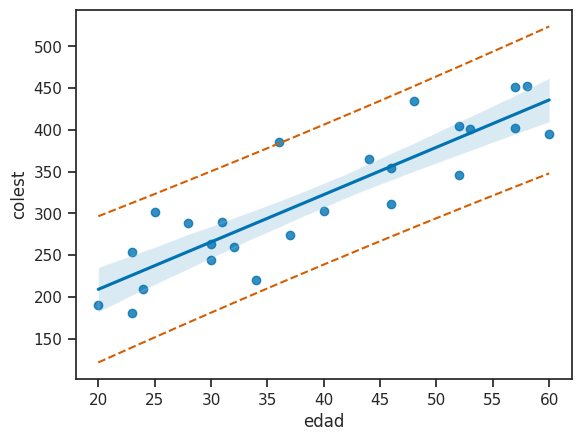

In [13]:
# Exporto a Python
%R -o nuevos_datos

# Grafico
sns.regplot(data=nuevos_datos, x='edad', y='colest')
sns.lineplot(data=nuevos_datos, x='edad', y='lwr', linestyle='--', color='r')
sns.lineplot(data=nuevos_datos, x='edad', y='upr', linestyle='--', color='r')
plt.show()

# x) Wald Test (revisar)
Mide si la Variable X es lo suficientemente significativa como para explicar la Y

#### R Magic

In [14]:
# # Wald Test -> Significatividad de cada Variable
# %%R

# library(aod)

# # Generamos el Modelo
# model_gorr = lm('Largo ~ Alas + Cabeza + Pata + Cuerpo', data=dataO)
# print(summary(model_gorr))

# # Wald Test para indentificar variables significativas
# wald.test(Sigma = vcov(model_gorr), b = coef(model_gorr), Terms = 4) # Cuerpo| H0: Coef = 0 (Var no significativa)


# 4) Residuals Normality With 0 Mean
Model residuals should follow a normal distribution, with 0 as mean

In [15]:
# Primero hay que generar el Modelo de Regresion Lineal
display(pg.normality(model_colest.resid))
print('Mean:', model_colest.resid.mean())

# If distribution is not normal, regression results will be biased
# and it may highlight that there are outliers or other assumptions being violated

,W,pval,normal
0,0.964775,0.517479,True


Mean: 5.0022208597511053e-14


# 5) Residuals Variance (Homosedasticity)
The variance of residual is the same for any value of x

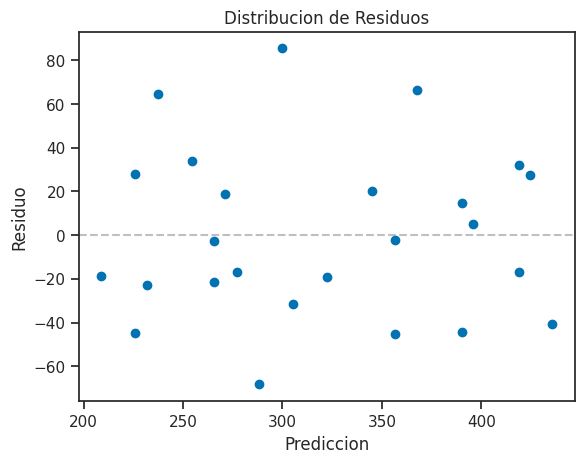

Estadistico BP y p-value: 0.15820998430559063 0.6908099159134585


In [16]:
# Analsis grafico a mano usando Matplotlib
plt.scatter(x=model_colest.predict(), y=model_colest.resid)
plt.xlabel( 'Prediccion')
plt.ylabel('Residuo')
plt.title('Distribucion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura de embudo

# Analitico (C Test) -> H0: Residuos Homocedasticos
BP, p_value, _, _ =sm.stats.het_breuschpagan(model_colest.resid, model_colest.model.exog)
print('Estadistico BP y p-value:', BP, p_value)

#### R Magic

In [17]:
# # Breusch-Pagan Homosedasticity Test
# %%R

# library(lmtest)
# bptest(model_colest_R)

# 6) Correlacion de Residuos
Aleatoriedad en el orden de las observacioens

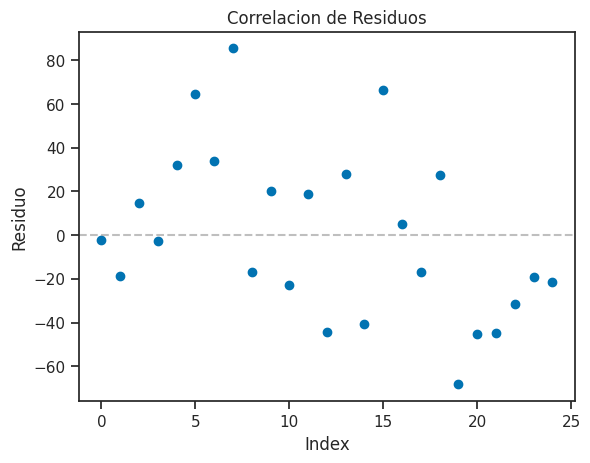

Durbin-Watson: 1.7830788132512603


In [18]:
# Analsis grafico a mano usando Matplotlib
plt.scatter(x=dataP.index, y=model_colest.resid)
plt.xlabel( 'Index')
plt.ylabel('Residuo')
plt.title('Correlacion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura

# Durbin-Watson Test: 2=No Correlacion (Independecia?)| 0=Correlacion Pos | 4=Correlacion Neg
print('Durbin-Watson:', sm.stats.durbin_watson(model_colest.resid)) # Sin validacion Estadistica

#### R Magic

In [19]:
# # Durbin-Watson No Auto-Correlation Test
# %%R

# library(lmtest)
# dwtest(model_colest_R, alternative='two.sided', iterations=1000) #H0 No Auto-Correlacion

# 7) Deteccion de Valores Outliers e Influyentes

In [28]:
# # No Outliers tests found in Python
%%R

# library(car)

# # Outliers - Bonferroni
# qqPlot(residuos)
# outlierTest(model_colest_R)
# influenceIndexPlot(model_colest_R, vars='Bonf')

# # Influyentes - Leverage
# crit_leverage <- 3*mean(hatvalues(model_colest_R))
# leverage <- hatvalues(model_colest_R) > crit_leverage
# print(sum(leverage))
# print(cbind(hatvalues(model_colest_R), crit_leverage, leverage))
# hist(hatvalues(model_colest_R))

# # Influyentes - Cook
# print(cooks.distance(model_colest_R))
# influenceIndexPlot(model_colest_R, vars='Cook')

# # Influyentes - DFFITS (revisar indices en plot)
# p <- length(model_colest_R$coefficients)
# n <- NROW(model_colest_R$residuals)
# dffits_crit <- 2*sqrt(p/n)
# dffits <- dffits(model_colest_R)
# data_dffits <- data.frame(dffits=dffits)


# # Influyentes - DFBetas
# dfbetas_crit <- 1 # Umbral estandard
# dfbetas(model_colest_R)[,2]>dfbetas_crit

# # Resumen
# plot(model_colest_R)
# summary(influence.measures(model=model_colest_R))
# influencePlot(model = model_colest_R)


[1] 3


In [21]:
# # Exporto a Python y grafico
# %R -o data_dffits
# %R -o dffits_crit

# data_dffits.head()
# sns.scatterplot(data=data_dffits, x=data_dffits.index, y='dffits')
# plt.axhline(y=dffits_crit, linestyle='--', color='red')
# plt.axhline(y=-dffits_crit, linestyle='--', color='red')

# plt.show()

# 9) Transformaciones
- Cuando los residuos no siguen una distribucion Normal -> Transformamos la y (BoxCox)
- Cuando los residuos tienen estructura -> Transformamos/Agregamos en X

In [22]:
# # Boc Cox Transformation Python
# # Verificamos la Normalidad de los residuos
# print(st.shapiro(model_cars.resid))
# data = dataC
# y = data['dist']

# # Calculo Lambda
# maxlog = st.boxcox(y)[1]
# st.boxcox_normplot(y, -2, 2, plt)
# plt.axvline(maxlog, color='red')
# plt.show()

# # Transfomracion: Si Lambda  = 0 -> np.log10(y) | y**Lambda
# y_trans = pd.Series(y**.5, name='y_trans')
# # No olvidarse de anti-transformar para los IC(10**predicted)

# # Generamos el nuevo Dataset con la y transformada
# data = pd.concat([data, y_trans], axis=1)

# # Generamos el nuevo modelo con la y_transformada
# model_cars_trans = smf.ols('y_trans ~ speed', data=data).fit()

# # Verificamos la nueva normalidad de los residuos
# print(pg.normality(model_cars_trans.resid))

In [23]:
# # Box Cox Transformation R

# %%R
# library(MASS)

# # Generamos el modelo y verificamos la Normalidad de los residuos
# mod_cars <- lm('dist ~ speed', data=dataC)
# print(shapiro.test(mod_cars$resid))

# # Buscamos el Landa optimo -> Si Lambda  = 0 -> log10(y) | y**Lambda
# boxcox(object = mod_cars, plotit=TRUE)

# # Generamos el nuevo modelo con la variable dependiente transformada, y verificamos su nueva normalidad
# mod_cars2 <- lm('dist**0.5 ~ speed', data=dataC)
# print(shapiro.test(mod_cars2$resid))

# # No olvidarse de anti-transformar en los IC, IP y Fit

# 10) Cuadrados Minimos Ponderados (WLS)
- Cuando los residuos son Heterocedasticos
- Se compensa la diferencia en los residuos, asignandole diferentes pesos a las observaciones

In [24]:
# # Cuadrados Minimos Ponderados (WLS) en R
# %%R

# # Generamos el modelo y verificamos la Heterocedasticidad de los residuos analiticamente
# ols_inspec <- lm('inspectores ~ choferes', data=dataCh)
# print(bptest(ols_inspec))

# # Confirmamos con el analisys grafico en Python

# # Generamos la ponderacion de pesos y modelamos de nuevo
# pesos = I(1/ols_onspec$fitted.values**2) # A los valores mas alejados se le reduce el peso
# pesos2 = 1 / lm(abs(ols_inspec$resid) ~ ols_inspec$fitted.values)$fitted.values**2 # Funciona mejor
# pesos3 = 1 / (abs(ols_inspec$resid))#**2

# # Modelamos con lo weigths
# wls_inspec <- lm('inspectores ~ choferes', data=dataCh, weights=pesos)
# print(summary(wls_inspec))

# # Verificar como graficar los modelos W en Python